# Deep Learning with PyTorch : Build a Generative Adversarial Network

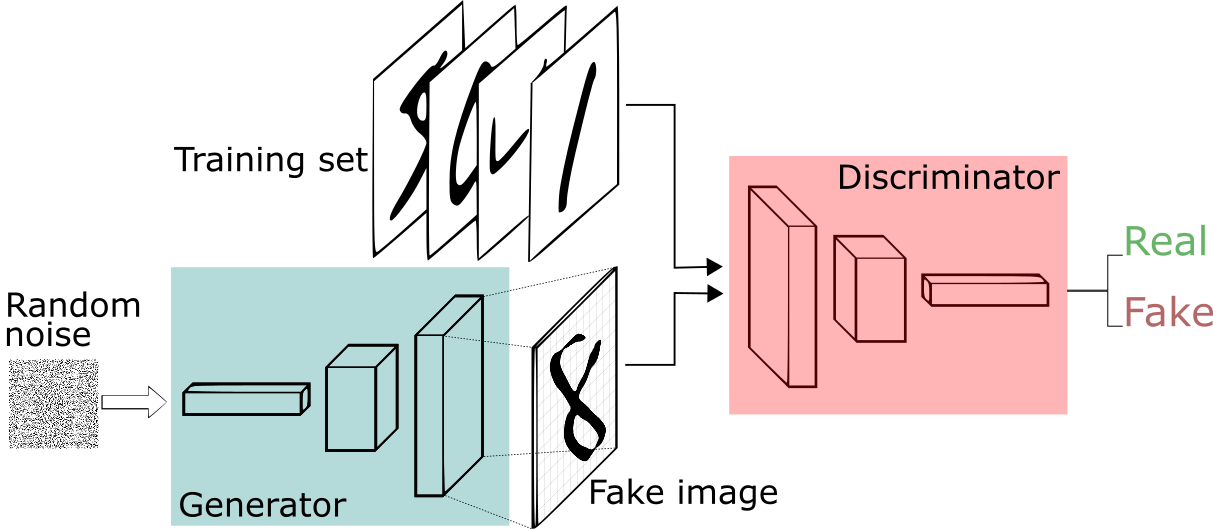

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cpu'    # usage: image = image.to(device); possible values: 'cpu', 'cuda'
batch_size = 128  # usage: trainloader, training loop
noise_dim = 64    # usage: generator model

# optimizer's parameters
lr = 0.0002       # learning rate
beta_1 = 0.5      # for Adam optimizer
beta_2 = 0.99     # for Adam optimizer

# Training variables
epochs = 20


# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)
])

In [5]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 34.6MB/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.62MB/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.25MB/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



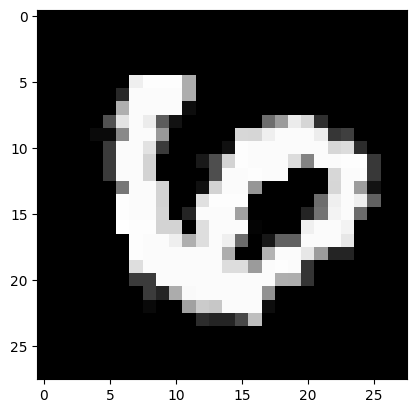

In [6]:
image, label = trainset[9000]

plt.imshow(image.squeeze(), cmap='gray')

In [7]:
print("Total images present in trainset are:", len(trainset))

Total images present in trainset are: 60000


# Load Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [10]:
print("Total number of batches in trainloader:", len(trainloader))

Total number of batches in trainloader: 469


In [11]:
dataiter = iter(trainloader)

images, _ = next(dataiter)

print(images.shape)

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

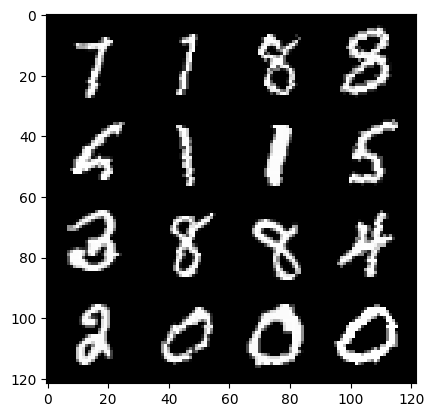

In [13]:
show_tensor_images(images, num_images=16)

# Create Discriminator Network

In [14]:
#In case if torch summary is not installed

!pip install torchsummary

In [15]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [19]:
def get_disc_block(in_channels: int, out_channels: int, kernel_size: tuple[int], stride: int):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [17]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)
    return x5


In [18]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [20]:
def get_gen_block(in_channels: int, out_channels: int, kernel_size: tuple[int], stride: int, is_final_block: bool = False):
  if is_final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [21]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)
    self.block_4 = get_gen_block(64, 1, (4,4), 2, is_final_block=True)

  def forward(self, random_noise_vec):
    # (batch_size, noise_dim) -> (batch_size, noise_dim, 1, 1)
    x = random_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)
    return x4

In [22]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [23]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [24]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [25]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [26]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.6820406754896331 | G_loss: 0.6938680620081643


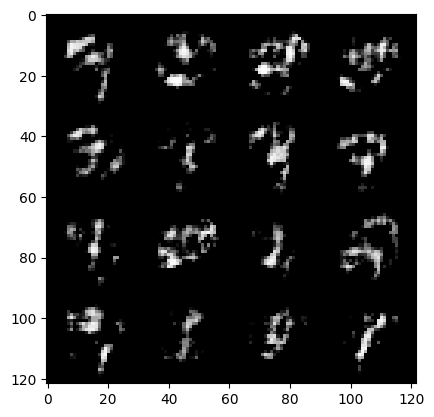

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.673857673144798 | G_loss: 0.7154025866278707


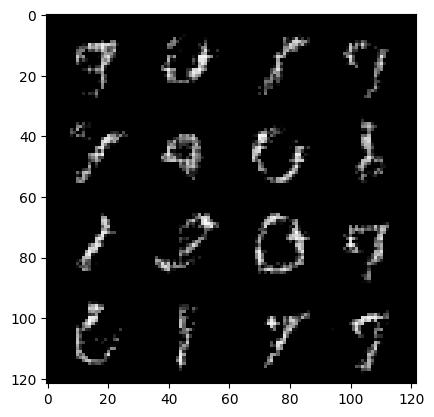

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.6358157769957585 | G_loss: 0.7560615455672177


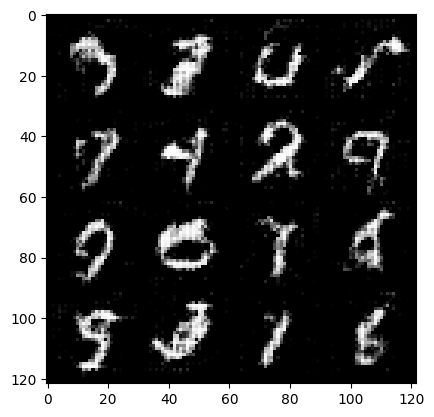

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.6183681368573642 | G_loss: 0.7840879975097266


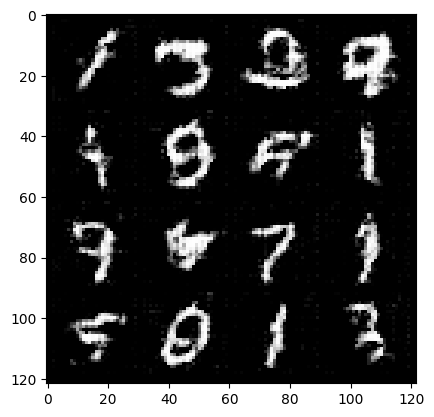

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.6116293039657413 | G_loss: 0.8032613746138778


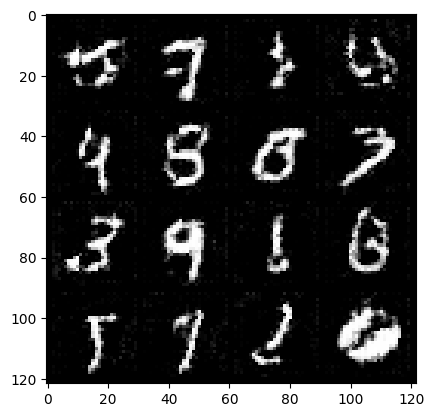

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.607903085410722 | G_loss: 0.8201201410690097


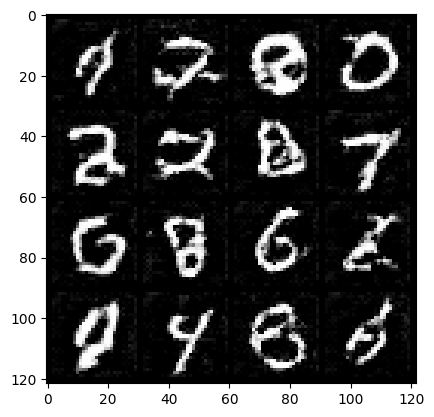

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.6159847918858152 | G_loss: 0.8193730073951201


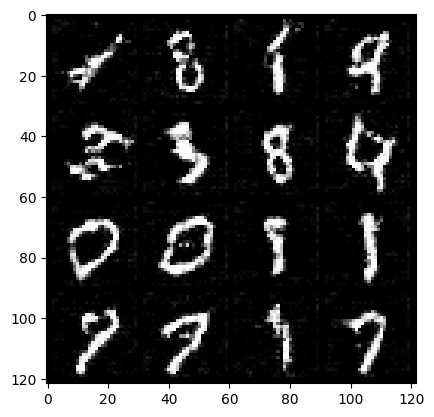

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.6252693619046893 | G_loss: 0.8142972705460815


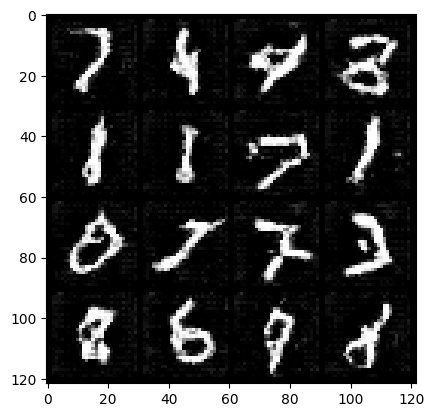

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.6316446613655415 | G_loss: 0.811059532135026


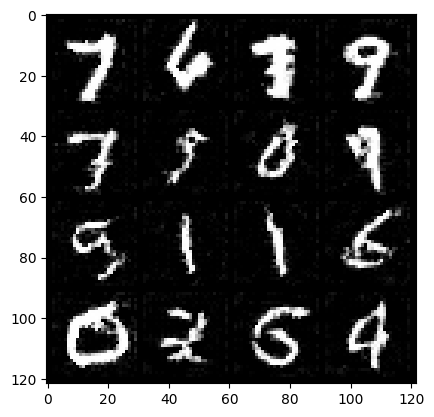

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.6365296666556076 | G_loss: 0.8041965158255115


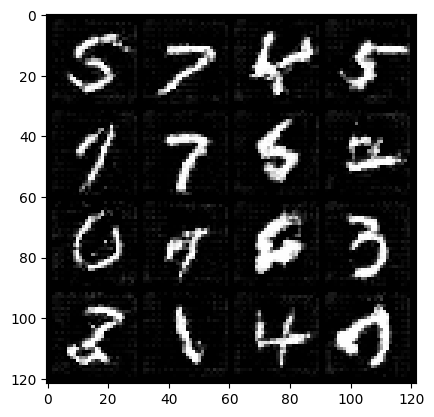

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.6416168942380307 | G_loss: 0.8042144772848849


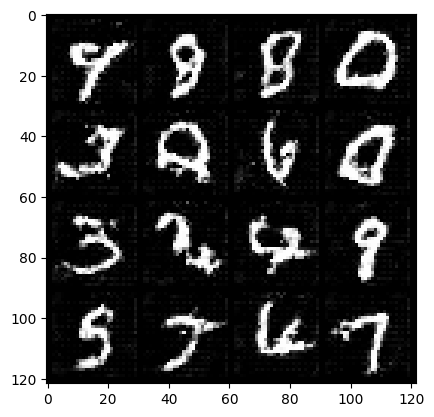

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.6440230024648882 | G_loss: 0.7996242435247913


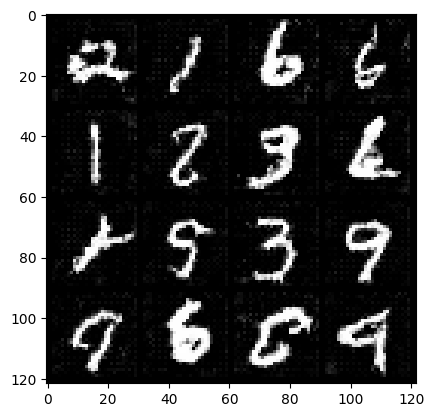

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.6468521875104924 | G_loss: 0.7976524176628097


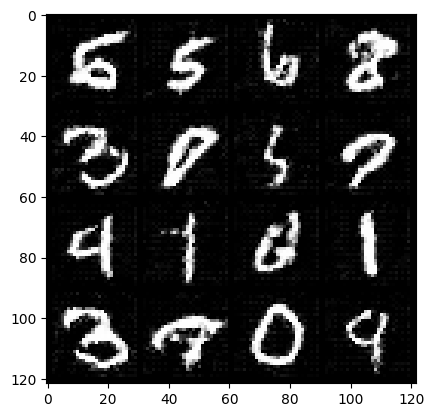

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.6452684518116624 | G_loss: 0.8015229599053926


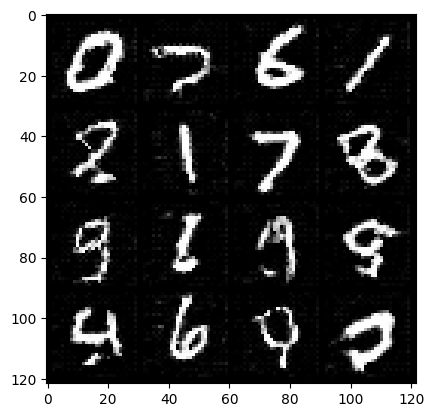

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.6455924460120293 | G_loss: 0.8002341519286638


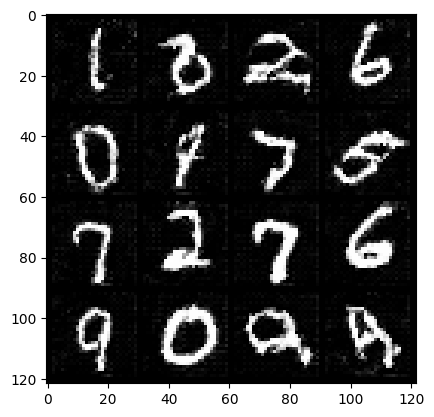

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.648114192206214 | G_loss: 0.7975853328257482


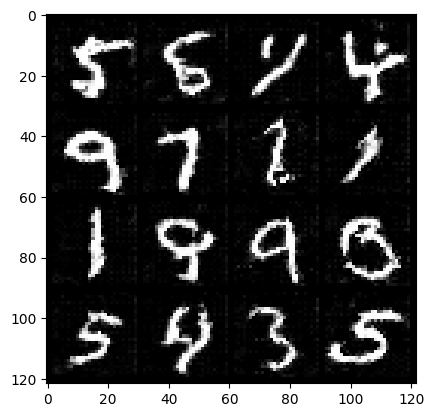

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.6485416585448455 | G_loss: 0.7981751079498324


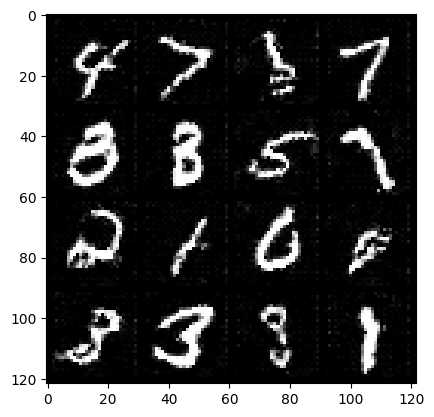

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.6483892809861759 | G_loss: 0.7982523128676262


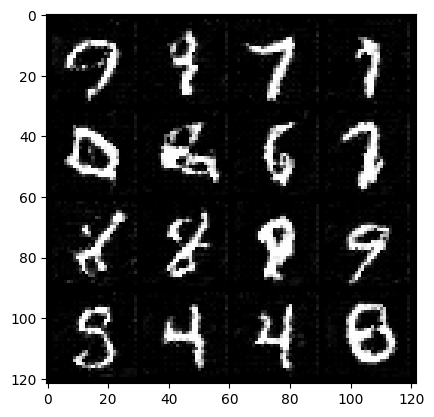

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.6488542123389905 | G_loss: 0.8000801252657925


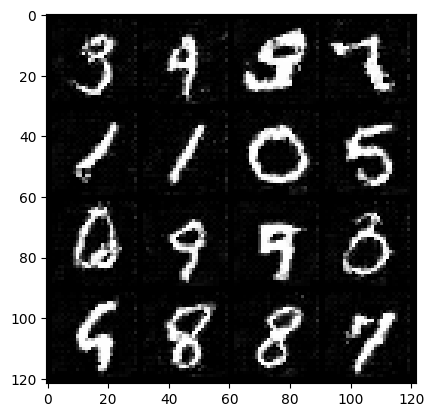

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.649052474417412 | G_loss: 0.7993900402268367


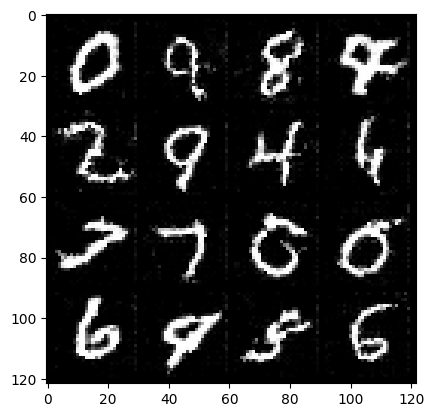

In [27]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    # find loss and update weight for D
    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss) / 2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # find loss and update weight for G
    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device=device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)


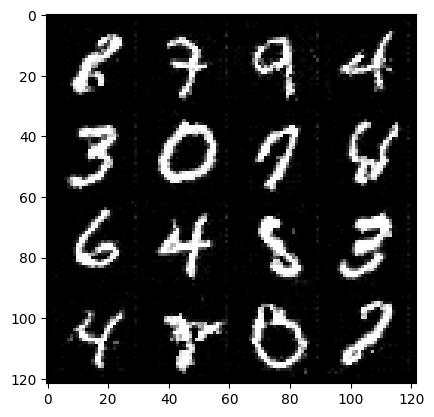

In [28]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya